## Unit 3 Capstone
In this notebook, I am going to try and predict which kids in a portugese school will need extra help in order to improve their scores 

In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.model_selection as ms
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.neighbors import KNeighborsRegressor
from sklearn import linear_model
from catboost import Pool, CatBoostClassifier, cv, CatboostIpythonWidget
from sklearn import preprocessing
from sklearn.decomposition import PCA 
from matplotlib.mlab import PCA as mlabPCA

In [2]:
#lets load the data
df = pd.read_csv(r'C:\Users\jmfra\OneDrive\Documents\Thinkful Data Science Files\3 capstone data\student-por.csv')

In [3]:
df

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13
5,GP,M,16,U,LE3,T,4,3,services,other,...,5,4,2,1,2,5,6,12,12,13
6,GP,M,16,U,LE3,T,2,2,other,other,...,4,4,4,1,1,3,0,13,12,13
7,GP,F,17,U,GT3,A,4,4,other,teacher,...,4,1,4,1,1,1,2,10,13,13
8,GP,M,15,U,LE3,A,3,2,services,other,...,4,2,2,1,1,1,0,15,16,17
9,GP,M,15,U,GT3,T,3,4,other,other,...,5,5,1,1,1,5,0,12,12,13


In [4]:
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13


In [5]:
#at first look the file has a few extra columns that python will hide so lets lengthen the display
pd.options.display.max_columns = 999

In [6]:
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,0,yes,no,no,no,yes,yes,yes,no,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,no,yes,yes,yes,yes,yes,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,no,no,yes,yes,no,no,4,3,2,1,2,5,0,11,13,13


In [7]:
#our independent variables are grades in 3 periods. the meta data describes G3 as some average of the first two. Assuming it is
#the score averaging 1 and 2 as well as some final test we will use this as our sole independent variable
df['AvgG'] = df['G3']
df = df.drop(['G1', 'G2', 'G3'],1)
df.AvgG.describe()

count    649.000000
mean      11.906009
std        3.230656
min        0.000000
25%       10.000000
50%       12.000000
75%       14.000000
max       19.000000
Name: AvgG, dtype: float64

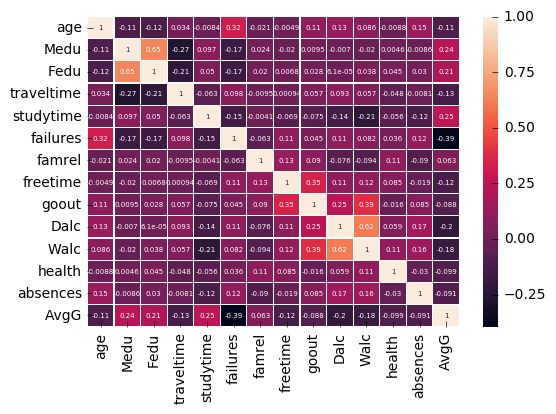

In [8]:
#lets check the already continous variables to see if there are any correlations
sns.heatmap(df.corr(), linewidths=.1, annot=True,annot_kws={'size': 5})
plt.show()

In [9]:
#number of times during the week and weekend a kid drinks are very directly related so lets combine them and make it total
#number of times the kid drinks during the entire week
df['Walc'] = df['Walc'] + df['Dalc']
df = df.drop('Dalc',1)

In [10]:
#from the meta data, Fedu and Medu deccribe the education level of each of a childs parents. We would expect the highest level of
#education in the family to be more important to a childs likelyhood of failing courses than each individual. lets create a knew
#column that contains the higher value from the two columns and then delete the originals
df['Famedu'] = np.where(df['Medu'] >= df['Fedu'], df['Medu'], df['Fedu'])
df = df.drop(['Medu', 'Fedu'], 1)

In [11]:
df['Mjob'].groupby(df['Pstatus']).count()

Pstatus
A     80
T    569
Name: Mjob, dtype: int64

In [12]:
df['Mjob'].groupby(df['guardian']).count()

guardian
father    153
mother    455
other      41
Name: Mjob, dtype: int64

In [13]:
#the only remaining column that sticks out is guardian. It lists the guardian of the parent as mother, father or other. My issue
#with this column is that even when the parents are not split up (Pstatus) a guardian is still listed, implying its arbitrary
#for a lot of the entries since 569 of the 649 entries are still together. It might be an important piece of information for some
#of these, but we do not have enough information to know which entries are important
df = df.drop('guardian',1) 

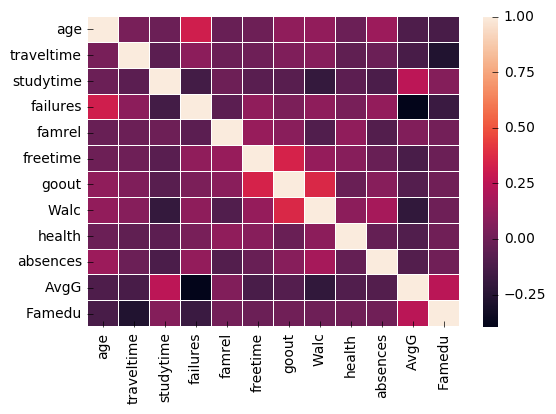

In [14]:
sns.heatmap(df.corr(), linewidths=.1)
plt.show()

In [15]:
#Now lets take all of the categorical variables with 2 inputs and transfer them into booleans to make them easy to work with
boolist = ['school', 'sex', 'address', 'famsize', 'Pstatus', 'schoolsup', 
           'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 
           'romantic']
for x in boolist:
    df[x] = pd.get_dummies(df[x])
df.head()

,school,sex,age,address,famsize,Pstatus,Mjob,Fjob,reason,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Walc,health,absences,AvgG,Famedu
0,1.0,1.0,18,0.0,1.0,1.0,at_home,teacher,course,2,2,0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,4,3,4,2,3,4,11,4
1,1.0,1.0,17,0.0,1.0,0.0,at_home,other,course,1,2,0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,5,3,3,2,3,2,11,1
2,1.0,1.0,15,0.0,0.0,0.0,at_home,other,other,1,2,0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,4,3,2,5,3,6,12,1
3,1.0,1.0,15,0.0,1.0,0.0,health,services,home,1,3,0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3,2,2,2,5,0,14,4
4,1.0,1.0,16,0.0,1.0,0.0,other,other,home,1,2,0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,4,3,2,3,5,0,13,3


In [16]:
#before we continue, getting dummies is the best way to handle categorical variables with more than 2 inputs, however there 
#might be an issue with having too many features since we have only 650 inputs so I am going to copy the data so we 
#can test both dummies and labelencoded variables
df_labelencode = df.copy()

In [17]:
#lets create columns for each input in the remaining categorical variables
l2 =['Mjob', 'Fjob', 'reason']
for x in l2:
    df = pd.concat([df, pd.get_dummies(df[x])], axis=1)
    df = df.drop(x,1)

In [18]:
df = df.astype('int64')

In [19]:
df.head()

,school,sex,age,address,famsize,Pstatus,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Walc,health,absences,AvgG,Famedu,at_home,health,other,services,teacher,at_home,health,other,services,teacher,course,home,other,reputation
0,1,1,18,0,1,1,2,2,0,0,1,1,1,0,0,1,1,4,3,4,2,3,4,11,4,1,0,0,0,0,0,0,0,0,1,1,0,0,0
1,1,1,17,0,1,0,1,2,0,1,0,1,1,1,0,0,1,5,3,3,2,3,2,11,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0
2,1,1,15,0,0,0,1,2,0,0,1,1,1,0,0,0,1,4,3,2,5,3,6,12,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0
3,1,1,15,0,1,0,1,3,0,1,0,1,0,0,0,0,0,3,2,2,2,5,0,14,4,0,1,0,0,0,0,0,0,1,0,0,1,0,0
4,1,1,16,0,1,0,1,2,0,1,0,1,1,0,0,1,1,4,3,2,3,5,0,13,3,0,0,1,0,0,0,0,1,0,0,0,1,0,0


In [20]:
#Now lets check a bunch of different regressors to see which one preforms the best on this data. I am going to add the train and
#test scores for the same groupings for each test into a dataset to easily compare them
X = df.drop('AvgG',1)
y = df.AvgG

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)
rfc = ensemble.RandomForestRegressor()
rfc.fit(X_train,y_train)
rfc_train = rfc.score(X_train,y_train)
rfc_test = rfc.score(X_test,y_test)

In [22]:
gbc = ensemble.GradientBoostingRegressor()
gbc.fit(X_train,y_train)
gbc_train = gbc.score(X_train,y_train)
gbc_test = gbc.score(X_test,y_test)

In [23]:
svr = svm.SVR()
svr.fit(X_train,y_train)
svr_train = svr.score(X_train,y_train)
svr_test = svr.score(X_test,y_test)

In [24]:
knn = KNeighborsRegressor()
knn.fit(X_train,y_train)
knn_train = knn.score(X_train,y_train)
knn_test = knn.score(X_test,y_test)

In [25]:
lr = linear_model.LinearRegression()
lr.fit(X_train,y_train)
lr_train = lr.score(X_train,y_train)
lr_test = lr.score(X_test,y_test)

In [26]:
scores = pd.DataFrame()
scores['test_score'] = [rfc_test, gbc_test, svr_test, knn_test, lr_test]
scores.index = ['random forest', 'gradient boost', 'svr', 'knn', 'linear']
scores

,test_score
random forest,0.281556
gradient boost,0.289326
svr,0.204295
knn,0.053274
linear,0.256138


In [27]:
#lets go ahead and try the same thing with label encoded variables like we discussed earlier to see if this improves anything
l2 =['age', 'Mjob', 'Fjob', 'reason']
for x in l2:
    le = preprocessing.LabelEncoder()
    le.fit(df_labelencode[x])
    df_labelencode[x] = le.transform(df_labelencode[x])
df_labelencode.head()

,school,sex,age,address,famsize,Pstatus,Mjob,Fjob,reason,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Walc,health,absences,AvgG,Famedu
0,1.0,1.0,3,0.0,1.0,1.0,0,4,0,2,2,0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,4,3,4,2,3,4,11,4
1,1.0,1.0,2,0.0,1.0,0.0,0,2,0,1,2,0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,5,3,3,2,3,2,11,1
2,1.0,1.0,0,0.0,0.0,0.0,0,2,2,1,2,0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,4,3,2,5,3,6,12,1
3,1.0,1.0,0,0.0,1.0,0.0,1,3,1,1,3,0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3,2,2,2,5,0,14,4
4,1.0,1.0,1,0.0,1.0,0.0,2,2,1,1,2,0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,4,3,2,3,5,0,13,3


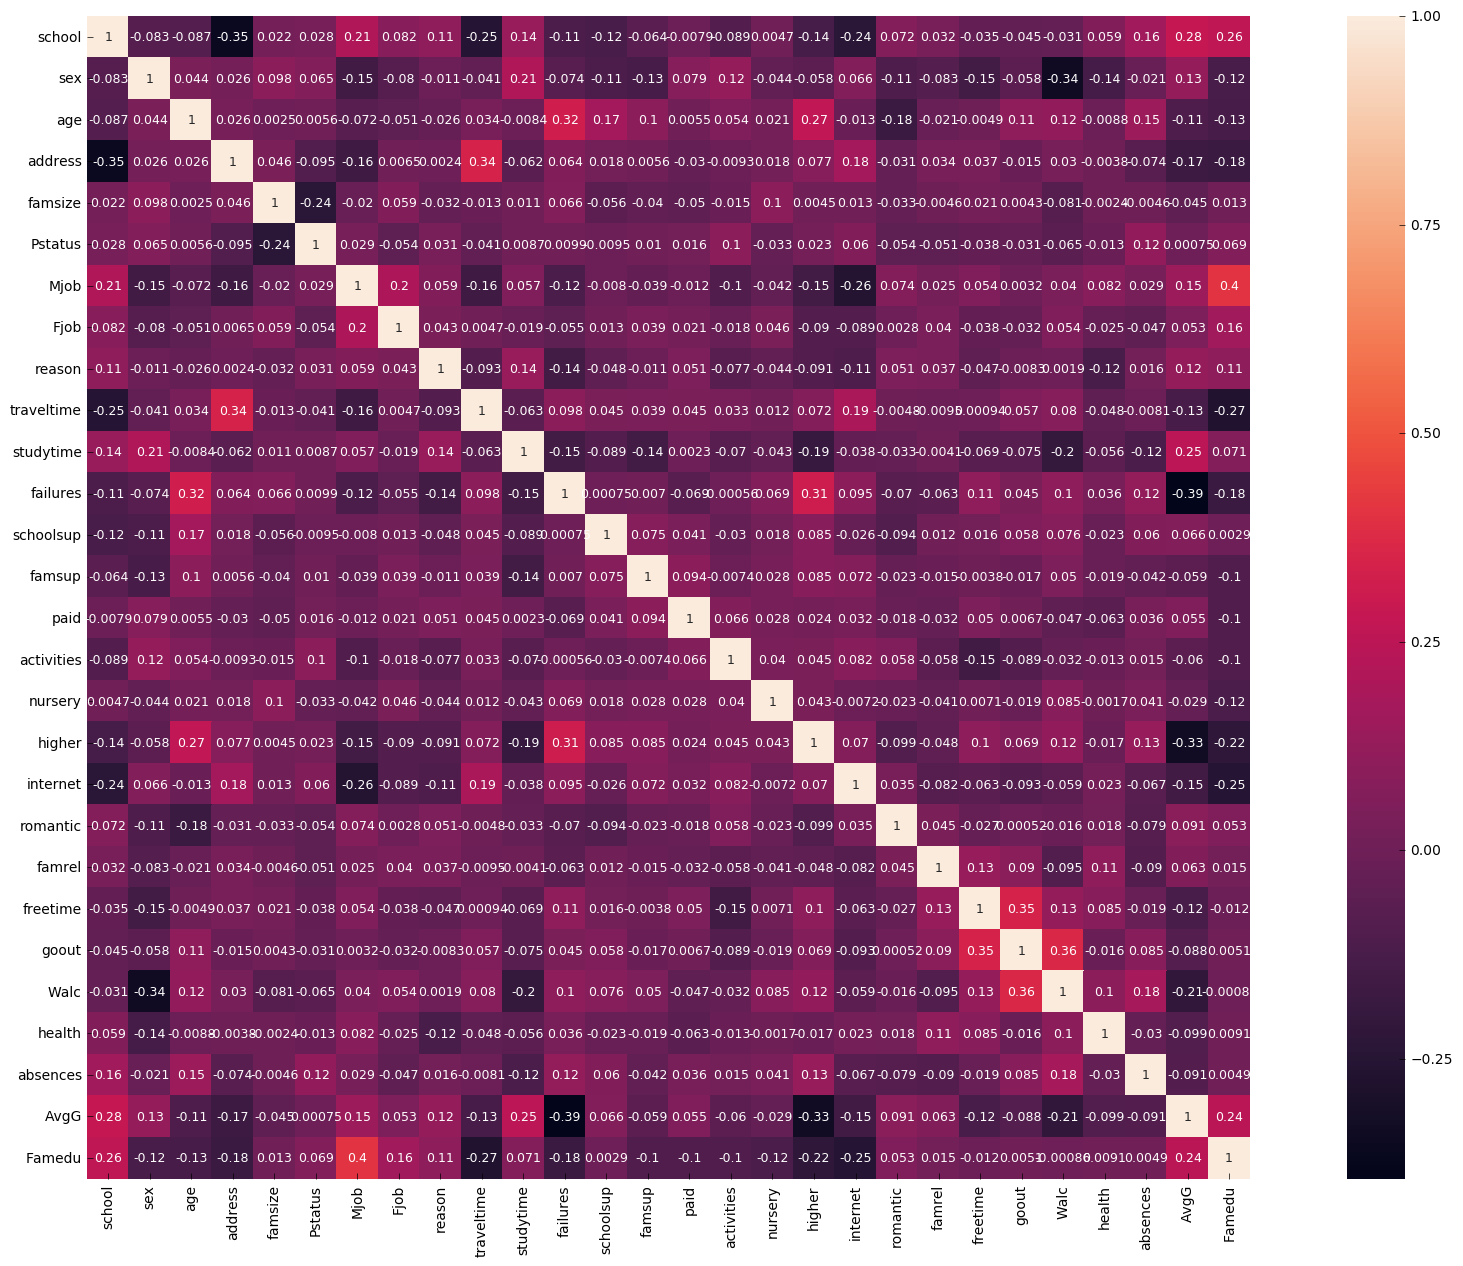

In [28]:
plt.figure(figsize=(25, 15)) # width and height in inches
sns.heatmap(df_labelencode.corr(), cbar = True,  square = True, annot=True,annot_kws={'size': 9})
plt.show()

In [29]:
X = df_labelencode.drop('AvgG',1)
y = df_labelencode.AvgG

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

rfc = ensemble.RandomForestRegressor()
rfc.fit(X_train,y_train)
rfc_train = rfc.score(X_train,y_train)
rfc_test = rfc.score(X_test,y_test)

gbc = ensemble.GradientBoostingRegressor()
gbc.fit(X_train,y_train)
gbc_train = gbc.score(X_train,y_train)
gbc_test = gbc.score(X_test,y_test)

svr = svm.SVR()
svr.fit(X_train,y_train)
svr_train = svr.score(X_train,y_train)
svr_test = svr.score(X_test,y_test)

knn = KNeighborsRegressor()
knn.fit(X_train,y_train)
knn_train = knn.score(X_train,y_train)
knn_test = knn.score(X_test,y_test)

lr = linear_model.LinearRegression()
lr.fit(X_train,y_train)
lr_train = lr.score(X_train,y_train)
lr_test = lr.score(X_test,y_test)

scores = pd.DataFrame()
scores['test_score'] = [rfc_test, gbc_test, svr_test, knn_test, lr_test]
scores.index = ['random forest', 'gradient boost', 'svr', 'knn', 'linear']
scores

,test_score
random forest,0.273122
gradient boost,0.301026
svr,0.203534
knn,0.059257
linear,0.283791


In [30]:
#these tests all show a clear pattern: the train set are overfitting the data way too much and we have to solve this
#in order to use this data we will likely have to turn the dependent varaible into a categorical variable instead of 
#a continuous one. There are a few different options here. We are going to try two and see which one improves performance
#more. We are going to seperate the kids into people who are likely to fail or pass and we are going to seperate kids
#who are exceptional, average, and under-performing. lets make another copy of the data set to try that first
df = df_labelencode.copy()
df1 = df_labelencode.copy()

In [31]:
#according to https://www.classbase.com/countries/Portugal/Grading-System, anything 10 or above is passing and anything 16 or 
#above is considered honors. Lets define those at the cut offs for the scale and see if the data roughly evenly distributed 
#where 0 is honors, 1 is average and 2 is failures
df1['AvgG'] = np.where(df1['AvgG'] <= 2, 2, df1['AvgG'])
df1['AvgG'] = np.where(df1['AvgG'] >= 16, 0, df1['AvgG'])
df1['AvgG'] = np.where(df1['AvgG'] >= 10, 1, df1['AvgG'])
df1['AvgG'] = np.where(df1['AvgG'] > 1, 2, df1['AvgG'])
df1['AvgG'].groupby(df1['AvgG']).count()

AvgG
0     82
1    467
2    100
Name: AvgG, dtype: int64

In [32]:
#there is an immediate issue in that there are a lot more kids who are average (1) than anyhting else
#we would expect the solver to predict close to all option to be average and still get a good score.
#lets run the test and see
X = df1.drop('AvgG',1)
y = df1.AvgG

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

rfc = ensemble.RandomForestClassifier()
rfc.fit(X_train,y_train)
pred_y = rfc.predict(X_test)
crosstab = pd.crosstab(pred_y, y_test)
rfc_fail = crosstab.iloc[2,2]
rfc_test = rfc.score(X_test,y_test)

gbc = ensemble.GradientBoostingClassifier()
gbc.fit(X_train,y_train)
pred_y = gbc.predict(X_test)
crosstab1 = pd.crosstab(pred_y, y_test)
gbc_fail = crosstab1.iloc[2,2]
gbc_test = gbc.score(X_test,y_test)

svr = svm.SVC()
svr.fit(X_train,y_train)
pred_y = svr.predict(X_test)
crosstab2 = pd.crosstab(pred_y, y_test)
svr_fail = 0
svr_test = svr.score(X_test,y_test)

lr1 = linear_model.LogisticRegression()
lr1.fit(X_train,y_train)
pred_y = lr1.predict(X_test)
crosstab3 = pd.crosstab(pred_y, y_test)
lr1_fail = crosstab3.iloc[2,2]
lr1_test = lr1.score(X_test,y_test)

lr2 = linear_model.LogisticRegression(penalty='l1')
lr2.fit(X_train,y_train)
pred_y = lr2.predict(X_test)
crosstab4 = pd.crosstab(pred_y, y_test)
lr2_fail = 0
lr2_test = lr2.score(X_test,y_test)

scores = pd.DataFrame()
scores['test_score'] = [rfc_test, gbc_test, svr_test, lr1_test, lr2_test]
scores['correctly predicted failures'] = [rfc_fail, gbc_fail, svr_fail, lr1_fail, lr2_fail]
scores.index = ['random forest', 'gradient boost', 'svc', 'ridge_log', 'lasso_log']
scores

,test_score,correctly predicted failures
random forest,0.695385,10
gradient boost,0.723077,13
svc,0.698462,0
ridge_log,0.713846,9
lasso_log,0.713846,0


In [33]:
#out of the 100 kids who failed, we are only correctly predicting 13 or less no matter the classifying approach, as expected
#lets check out the crosstabs 
crosstab

AvgG,0,1,2
row_0,,,
0,5,11,1
1,37,211,45
2,0,5,10


In [34]:
crosstab1

AvgG,0,1,2
row_0,,,
0,6,5,1
1,36,216,42
2,0,6,13


In [35]:
crosstab2

AvgG,0,1,2
row_0,,,
1,42,227,56


In [36]:
crosstab3

AvgG,0,1,2
row_0,,,
0,1,0,0
1,41,222,47
2,0,5,9


In [37]:
crosstab4

AvgG,0,1,2
row_0,,,
1,42,223,47
2,0,4,9


In [38]:
rfc_fail = crosstab.iloc[0,0]/(crosstab.iloc[0,0]+crosstab.iloc[1,0])
rfc_fail

0.11904761904761904

In [39]:
#we are going to need to change the parameters of the groups if we ever want a model that predicts the under represented groups
#with any efficiency. lets try evening them out as much as possible based on the original parameters
df2 = df_labelencode.copy()
df2['AvgG'] = np.where(df2['AvgG'] <= 2, 2, df2['AvgG'])
df2['AvgG'] = np.where(df2['AvgG'] >= 14, 0, df2['AvgG'])
df2['AvgG'] = np.where(df2['AvgG'] >= 11, 1, df2['AvgG'])
df2['AvgG'] = np.where(df2['AvgG'] > 1, 2, df2['AvgG'])
df2['AvgG'].groupby(df2['AvgG']).count()

AvgG
0    194
1    258
2    197
Name: AvgG, dtype: int64

In [40]:
#changing the cutoffs to 11 and 14 instead of 10 and 16, the groups are much more even
X = df2.drop('AvgG', 1)
y = df2.AvgG

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

In [42]:
rfc = ensemble.RandomForestClassifier()
rfc.fit(X_train,y_train)
pred_y = rfc.predict(X_test)
crosstab = pd.crosstab(pred_y, y_test)
rfc_fail = crosstab.iloc[2,2]
rfc_test = rfc.score(X_test,y_test)

gbc = ensemble.GradientBoostingClassifier()
gbc.fit(X_train,y_train)
pred_y = gbc.predict(X_test)
crosstab1 = pd.crosstab(pred_y, y_test)
gbc_fail = crosstab1.iloc[2,2]
gbc_test = gbc.score(X_test,y_test)

svr = svm.SVC()
svr.fit(X_train,y_train)
pred_y = svr.predict(X_test)
crosstab2 = pd.crosstab(pred_y, y_test)
svr_fail = crosstab2.iloc[2,2]
svr_test = svr.score(X_test,y_test)

lr1 = linear_model.LogisticRegression()
lr1.fit(X_train,y_train)
pred_y = lr1.predict(X_test)
crosstab3 = pd.crosstab(pred_y, y_test)
lr1_fail = crosstab3.iloc[2,2]
lr1_test = lr1.score(X_test,y_test)

lr2 = linear_model.LogisticRegression(penalty='l1')
lr2.fit(X_train,y_train)
pred_y = lr2.predict(X_test)
crosstab4 = pd.crosstab(pred_y, y_test)
lr2_fail = crosstab4.iloc[2,2]
lr2_test = lr2.score(X_test,y_test)

scores = pd.DataFrame()
scores['test_score'] = [rfc_test, gbc_test, svr_test, lr1_test, lr2_test]
scores['correctly predicted failures'] = [rfc_fail, gbc_fail, svr_fail, lr1_fail, lr2_fail]
scores.index = ['random forest', 'gradient boost', 'svc', 'ridge_log', 'lasso_log']
scores

,test_score,correctly predicted failures
random forest,0.523077,48
gradient boost,0.538462,48
svc,0.526154,45
ridge_log,0.587692,52
lasso_log,0.593846,53


In [43]:
crosstab2

AvgG,0,1,2
row_0,,,
0,52,43,11
1,36,74,46
2,5,13,45


In [44]:
#while massively imrpoving the guessing of the small categories, we hurt the overall model by around 15% for every test.
#while this is much better than the regressor, 55% is still a rough place to start. lets change it into a boolean as 
#discussed before in order to improve even further with an initial cutoff at the failing line we defined earlier
dff = df.copy()
dff1 = df.copy()
df['AvgG'] = np.where(df['AvgG'] >= 10, 1, 0)

In [45]:
df['AvgG'].groupby(df['AvgG']).count()

AvgG
0    100
1    549
Name: AvgG, dtype: int64

In [46]:
#again we will probably have an issue with the groups since one has 5.5x the entries. we are going to do this boolean test
#a few times until the groups are even just to test the difference
dff['AvgG'] = np.where(dff['AvgG'] >= 11, 1, 0)
dff['AvgG'].groupby(dff['AvgG']).count()

AvgG
0    197
1    452
Name: AvgG, dtype: int64

In [47]:
dff1['AvgG'] = np.where(dff1['AvgG'] >= 12, 1, 0)
dff1['AvgG'].groupby(dff1['AvgG']).count()

AvgG
0    301
1    348
Name: AvgG, dtype: int64

In [48]:
X1 = df.drop('AvgG', 1)
y1 = df.AvgG
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.5, random_state=0)

rfc = ensemble.RandomForestClassifier()
rfc.fit(X_train,y_train)
pred_y = rfc.predict(X_test)
crosstab = pd.crosstab(pred_y, y_test)
rfc_fail = crosstab.iloc[0,0]/(crosstab.iloc[0,0]+crosstab.iloc[1,0])
rfc_test = rfc.score(X_test,y_test)

gbc = ensemble.GradientBoostingClassifier()
gbc.fit(X_train,y_train)
pred_y = gbc.predict(X_test)
crosstab1 = pd.crosstab(pred_y, y_test)
gbc_fail = crosstab1.iloc[0,0]/(crosstab1.iloc[0,0]+crosstab1.iloc[1,0])
gbc_test = gbc.score(X_test,y_test)

svr = svm.SVC()
svr.fit(X_train,y_train)
pred_y = svr.predict(X_test)
crosstab2 = pd.crosstab(pred_y, y_test)
svr_fail = 0
svr_test = svr.score(X_test,y_test)

lr1 = linear_model.LogisticRegression()
lr1.fit(X_train,y_train)
pred_y = lr1.predict(X_test)
crosstab3 = pd.crosstab(pred_y, y_test)
lr1_fail = crosstab3.iloc[0,0]/(crosstab3.iloc[0,0]+crosstab3.iloc[1,0])
lr1_test = lr1.score(X_test,y_test)

lr2 = linear_model.LogisticRegression(penalty='l1')
lr2.fit(X_train,y_train)
pred_y = lr2.predict(X_test)
crosstab4 = pd.crosstab(pred_y, y_test)
lr2_fail = crosstab4.iloc[0,0]/(crosstab4.iloc[0,0]+crosstab4.iloc[1,0])
lr2_test = lr2.score(X_test,y_test)

scores = pd.DataFrame()
scores['test_score'] = [rfc_test, gbc_test, svr_test, lr1_test, lr2_test]
scores['predicted failure percentage'] = [rfc_fail, gbc_fail, svr_fail, lr1_fail, lr2_fail]
scores.index = ['random forest', 'gradient boost', 'svc', 'ridge_log', 'lasso_log']
scores

,test_score,predicted failure percentage
random forest,0.830769,0.196429
gradient boost,0.849231,0.214286
svc,0.827692,0.000000
ridge_log,0.855385,0.232143
lasso_log,0.852308,0.232143


In [49]:
#as predicted the cutoff as 10 predicts in the 85% range but butchers guessing who will fail
X1 = dff.drop('AvgG', 1)
y1 = dff.AvgG
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.5, random_state=0)

rfc = ensemble.RandomForestClassifier()
rfc.fit(X_train,y_train)
pred_y = rfc.predict(X_test)
crosstab = pd.crosstab(pred_y, y_test)
rfc_fail = crosstab.iloc[0,0]/(crosstab.iloc[0,0]+crosstab.iloc[1,0])
rfc_test = rfc.score(X_test,y_test)

gbc = ensemble.GradientBoostingClassifier()
gbc.fit(X_train,y_train)
pred_y = gbc.predict(X_test)
crosstab1 = pd.crosstab(pred_y, y_test)
gbc_fail = crosstab1.iloc[0,0]/(crosstab1.iloc[0,0]+crosstab1.iloc[1,0])
gbc_test = gbc.score(X_test,y_test)

svr = svm.SVC()
svr.fit(X_train,y_train)
pred_y = svr.predict(X_test)
crosstab2 = pd.crosstab(pred_y, y_test)
svr_fail = crosstab2.iloc[0,0]/(crosstab2.iloc[0,0]+crosstab2.iloc[1,0])
svr_test = svr.score(X_test,y_test)

lr1 = linear_model.LogisticRegression()
lr1.fit(X_train,y_train)
pred_y = lr1.predict(X_test)
crosstab3 = pd.crosstab(pred_y, y_test)
lr1_fail = crosstab3.iloc[0,0]/(crosstab3.iloc[0,0]+crosstab3.iloc[1,0])
lr1_test = lr1.score(X_test,y_test)

lr2 = linear_model.LogisticRegression(penalty='l1')
lr2.fit(X_train,y_train)
pred_y = lr2.predict(X_test)
crosstab4 = pd.crosstab(pred_y, y_test)
lr2_fail = crosstab4.iloc[0,0]/(crosstab4.iloc[0,0]+crosstab4.iloc[1,0])
lr2_test = lr2.score(X_test,y_test)

scores = pd.DataFrame()
scores['test_score'] = [rfc_test, gbc_test, svr_test, lr1_test, lr2_test]
scores['predicted failure percentage'] = [rfc_fail, gbc_fail, svr_fail, lr1_fail, lr2_fail]
scores.index = ['random forest', 'gradient boost', 'svc', 'ridge_log', 'lasso_log']
scores

,test_score,predicted failure percentage
random forest,0.760000,0.490196
gradient boost,0.772308,0.441176
svc,0.729231,0.215686
ridge_log,0.790769,0.441176
lasso_log,0.800000,0.450980


In [50]:
#losing 5% or so accuracy improves guessing who will fail by 20% in a lot of casses, but under 50% in most is still not good enough
X1 = dff1.drop('AvgG', 1)
y1 = dff1.AvgG
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.5, random_state=0)

rfc = ensemble.RandomForestClassifier()
rfc.fit(X_train,y_train)
pred_y = rfc.predict(X_test)
crosstab = pd.crosstab(pred_y, y_test)
rfc_fail = crosstab.iloc[0,0]/(crosstab.iloc[0,0]+crosstab.iloc[1,0])
rfc_test = rfc.score(X_test,y_test)

gbc = ensemble.GradientBoostingClassifier()
gbc.fit(X_train,y_train)
pred_y = gbc.predict(X_test)
crosstab1 = pd.crosstab(pred_y, y_test)
gbc_fail = crosstab1.iloc[0,0]/(crosstab1.iloc[0,0]+crosstab1.iloc[1,0])
gbc_test = gbc.score(X_test,y_test)

svr = svm.SVC()
svr.fit(X_train,y_train)
pred_y = svr.predict(X_test)
crosstab2 = pd.crosstab(pred_y, y_test)
svr_fail = crosstab2.iloc[0,0]/(crosstab2.iloc[0,0]+crosstab2.iloc[1,0])
svr_test = svr.score(X_test,y_test)

lr1 = linear_model.LogisticRegression()
lr1.fit(X_train,y_train)
pred_y = lr1.predict(X_test)
crosstab3 = pd.crosstab(pred_y, y_test)
lr1_fail = crosstab3.iloc[0,0]/(crosstab3.iloc[0,0]+crosstab3.iloc[1,0])
lr1_test = lr1.score(X_test,y_test)

lr2 = linear_model.LogisticRegression(penalty='l1')
lr2.fit(X_train,y_train)
pred_y = lr2.predict(X_test)
crosstab4 = pd.crosstab(pred_y, y_test)
lr2_fail = crosstab4.iloc[0,0]/(crosstab4.iloc[0,0]+crosstab4.iloc[1,0])
lr2_test = lr2.score(X_test,y_test)

scores = pd.DataFrame()
scores['test_score'] = [rfc_test, gbc_test, svr_test, lr1_test, lr2_test]
scores['predicted failure percentage'] = [rfc_fail, gbc_fail, svr_fail, lr1_fail, lr2_fail]
scores.index = ['random forest', 'gradient boost', 'svc', 'ridge_log', 'lasso_log']
scores

,test_score,predicted failure percentage
random forest,0.676923,0.673333
gradient boost,0.756923,0.720000
svc,0.726154,0.660000
ridge_log,0.747692,0.640000
lasso_log,0.760000,0.646667


In [51]:
#these numbers are definitely looking better, but still none of the test end with a satisfactory split. lets try to even out the 
#groups exactly in all 3 cutoffs so see if we can improve performance. we will randomly select an even number of passing students
#from each cutoff so that an exactly equal number of fails and passes exist in each sample set
number_of_fails = len(df[df.AvgG == 0])
fail_indices = np.array(df[df.AvgG == 0].index)
pass_indices = df[df.AvgG == 1].index
random_pass_indices = np.array(np.random.choice(pass_indices, number_of_fails, replace = False))
new_indices = np.concatenate([fail_indices,random_pass_indices])
data = df.iloc[new_indices,:]
X = data.drop('AvgG', 1)
y = data.AvgG

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

rfc = ensemble.RandomForestClassifier()
rfc.fit(X_train,y_train)
pred_y = rfc.predict(X_test)
crosstab = pd.crosstab(pred_y, y_test)
rfc_fail = crosstab.iloc[0,0]/(crosstab.iloc[0,0]+crosstab.iloc[1,0])
rfc_test = rfc.score(X_test,y_test)

gbc = ensemble.GradientBoostingClassifier()
gbc.fit(X_train,y_train)
pred_y = gbc.predict(X_test)
crosstab1 = pd.crosstab(pred_y, y_test)
gbc_fail = crosstab1.iloc[0,0]/(crosstab1.iloc[0,0]+crosstab1.iloc[1,0])
gbc_test = gbc.score(X_test,y_test)

svr = svm.SVC()
svr.fit(X_train,y_train)
pred_y = svr.predict(X_test)
crosstab2 = pd.crosstab(pred_y, y_test)
svr_fail = crosstab2.iloc[0,0]/(crosstab2.iloc[0,0]+crosstab2.iloc[1,0])
svr_test = svr.score(X_test,y_test)

lr1 = linear_model.LogisticRegression()
lr1.fit(X_train,y_train)
pred_y = lr1.predict(X_test)
crosstab3 = pd.crosstab(pred_y, y_test)
lr1_fail = crosstab3.iloc[0,0]/(crosstab3.iloc[0,0]+crosstab3.iloc[1,0])
lr1_test = lr1.score(X_test,y_test)

lr2 = linear_model.LogisticRegression(penalty='l1')
lr2.fit(X_train,y_train)
pred_y = lr2.predict(X_test)
crosstab4 = pd.crosstab(pred_y, y_test)
lr2_fail = crosstab4.iloc[0,0]/(crosstab4.iloc[0,0]+crosstab4.iloc[1,0])
lr2_test = lr2.score(X_test,y_test)

scores = pd.DataFrame()
scores['test_score'] = [rfc_test, gbc_test, svr_test, lr1_test, lr2_test]
scores['predicted failure percentage'] = [rfc_fail, gbc_fail, svr_fail, lr1_fail, lr2_fail]
scores.index = ['random forest', 'gradient boost', 'svc', 'ridge_log', 'lasso_log']
scores

,test_score,predicted failure percentage
random forest,0.67,0.744681
gradient boost,0.71,0.638298
svc,0.66,0.702128
ridge_log,0.70,0.723404
lasso_log,0.72,0.723404


In [53]:
number_of_fails = len(dff[dff.AvgG == 0])
fail_indices = np.array(dff[dff.AvgG == 0].index)
pass_indices = dff[dff.AvgG == 1].index
random_pass_indices = np.array(np.random.choice(pass_indices, number_of_fails, replace = False))
new_indices = np.concatenate([fail_indices,random_pass_indices])
data1 = dff.iloc[new_indices,:]
X = data1.drop('AvgG', 1)
y = data1.AvgG

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

rfc = ensemble.RandomForestClassifier()
rfc.fit(X_train,y_train)
pred_y = rfc.predict(X_test)
crosstab = pd.crosstab(pred_y, y_test)
rfc_fail = crosstab.iloc[0,0]/(crosstab.iloc[0,0]+crosstab.iloc[1,0])
rfc_test = rfc.score(X_test,y_test)

gbc = ensemble.GradientBoostingClassifier()
gbc.fit(X_train,y_train)
pred_y = gbc.predict(X_test)
crosstab1 = pd.crosstab(pred_y, y_test)
gbc_fail = crosstab1.iloc[0,0]/(crosstab1.iloc[0,0]+crosstab1.iloc[1,0])
gbc_test = gbc.score(X_test,y_test)

svr = svm.SVC()
svr.fit(X_train,y_train)
pred_y = svr.predict(X_test)
crosstab2 = pd.crosstab(pred_y, y_test)
svr_fail = crosstab2.iloc[0,0]/(crosstab2.iloc[0,0]+crosstab2.iloc[1,0])
svr_test = svr.score(X_test,y_test)

lr1 = linear_model.LogisticRegression()
lr1.fit(X_train,y_train)
pred_y = lr1.predict(X_test)
crosstab3 = pd.crosstab(pred_y, y_test)
lr1_fail = crosstab3.iloc[0,0]/(crosstab3.iloc[0,0]+crosstab3.iloc[1,0])
lr1_test = lr1.score(X_test,y_test)

lr2 = linear_model.LogisticRegression(penalty='l1')
lr2.fit(X_train,y_train)
pred_y = lr2.predict(X_test)
crosstab4 = pd.crosstab(pred_y, y_test)
lr2_fail = crosstab4.iloc[0,0]/(crosstab4.iloc[0,0]+crosstab4.iloc[1,0])
lr2_test = lr2.score(X_test,y_test)

scores = pd.DataFrame()
scores['test_score'] = [rfc_test, gbc_test, svr_test, lr1_test, lr2_test]
scores['predicted failure percentage'] = [rfc_fail, gbc_fail, svr_fail, lr1_fail, lr2_fail]
scores.index = ['random forest', 'gradient boost', 'svc', 'ridge_log', 'lasso_log']
scores

,test_score,predicted failure percentage
random forest,0.659898,0.694737
gradient boost,0.685279,0.621053
svc,0.710660,0.715789
ridge_log,0.634518,0.621053
lasso_log,0.654822,0.621053


In [55]:
number_of_fails = len(dff1[dff1.AvgG == 0])
fail_indices = np.array(dff1[dff1.AvgG == 0].index)
pass_indices = dff1[dff1.AvgG == 1].index
random_pass_indices = np.array(np.random.choice(pass_indices, number_of_fails, replace = False))
new_indices = np.concatenate([fail_indices,random_pass_indices])
data2 = dff1.iloc[new_indices,:]
X = data2.drop('AvgG', 1)
y = data2.AvgG

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

rfc = ensemble.RandomForestClassifier()
rfc.fit(X_train,y_train)
pred_y = rfc.predict(X_test)
crosstab = pd.crosstab(pred_y, y_test)
rfc_fail = crosstab.iloc[0,0]/(crosstab.iloc[0,0]+crosstab.iloc[1,0])
rfc_test = rfc.score(X_test,y_test)

gbc = ensemble.GradientBoostingClassifier()
gbc.fit(X_train,y_train)
pred_y = gbc.predict(X_test)
crosstab1 = pd.crosstab(pred_y, y_test)
gbc_fail = crosstab1.iloc[0,0]/(crosstab1.iloc[0,0]+crosstab1.iloc[1,0])
gbc_test = gbc.score(X_test,y_test)

svr = svm.SVC()
svr.fit(X_train,y_train)
pred_y = svr.predict(X_test)
crosstab2 = pd.crosstab(pred_y, y_test)
svr_fail = crosstab2.iloc[0,0]/(crosstab2.iloc[0,0]+crosstab2.iloc[1,0])
svr_test = svr.score(X_test,y_test)

lr1 = linear_model.LogisticRegression()
lr1.fit(X_train,y_train)
pred_y = lr1.predict(X_test)
crosstab3 = pd.crosstab(pred_y, y_test)
lr1_fail = crosstab3.iloc[0,0]/(crosstab3.iloc[0,0]+crosstab3.iloc[1,0])
lr1_test = lr1.score(X_test,y_test)

lr2 = linear_model.LogisticRegression(penalty='l1')
lr2.fit(X_train,y_train)
pred_y = lr2.predict(X_test)
crosstab4 = pd.crosstab(pred_y, y_test)
lr2_fail = crosstab4.iloc[0,0]/(crosstab4.iloc[0,0]+crosstab4.iloc[1,0])
lr2_test = lr2.score(X_test,y_test)

scores = pd.DataFrame()
scores['test_score'] = [rfc_test, gbc_test, svr_test, lr1_test, lr2_test]
scores['predicted failure percentage'] = [rfc_fail, gbc_fail, svr_fail, lr1_fail, lr2_fail]
scores.index = ['random forest', 'gradient boost', 'svc', 'ridge_log', 'lasso_log']
scores

,test_score,predicted failure percentage
random forest,0.687708,0.762238
gradient boost,0.747508,0.755245
svc,0.727575,0.755245
ridge_log,0.737542,0.734266
lasso_log,0.754153,0.741259


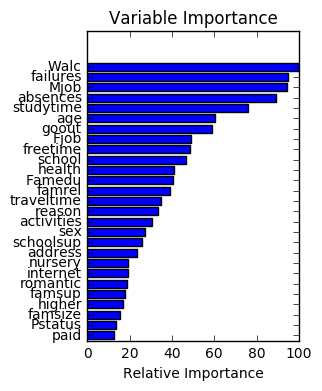

In [57]:
#as you can see, this method improves or worsens each model by up to 100% while never reaching the 80% mark. I do not think any
#similar transformations will help so lets check the features using random forests' built in code and displayig it in a graph
feature_importance = rfc.feature_importances_
# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [58]:
#by running the code above multiple times, you can see that the features swap around spots 
#this implies that the features are interchangeable in the model which is an issue for the same reason we decided to stick 
#with label encoded variables over dummy variables
#lets try PCA on the set to see if it can reduce the number of features
unimp = data2.drop('AvgG',1)
pca = PCA(n_components = 'mle', svd_solver = 'full')
pca.fit(unimp)

PCA(copy=True, iterated_power='auto', n_components='mle', random_state=None,
  svd_solver='full', tol=0.0, whiten=False)

In [59]:
pca.explained_variance_ratio_

array([ 0.53211973,  0.10385967,  0.05523564,  0.05046362,  0.03666172,
        0.03382653,  0.03167602,  0.0205204 ,  0.0200034 ,  0.01728829,
        0.01584347,  0.01460103,  0.01231265,  0.00726316,  0.00616314,
        0.00600239,  0.00525192,  0.00506644,  0.0048143 ,  0.00388276,
        0.00340624,  0.00335001,  0.00311929,  0.00212854,  0.0020458 ,
        0.00183292])

In [60]:
#unfortunately, PCA only get rid of 1 total column
pca_data = pd.DataFrame(pca.transform(unimp), columns=['PCA%i' % i for i in range(26)])

In [61]:
data2 = pd.concat([data2.AvgG, pca_data], axis=1)

In [62]:
data2 = data2.dropna(axis=0, how='any')

In [63]:
#lets retry random forest on the new set to see how it scores
X = data2.drop('AvgG', 1)
y = data2.AvgG
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

rfc = ensemble.RandomForestClassifier()
rfc.fit(X_train,y_train)
pred_y = rfc.predict(X_test)
crosstab = pd.crosstab(pred_y, y_test)
crosstab

AvgG,0.0,1.0
row_0,,
0.0,79,74
1.0,62,65


In [64]:
rfc.score(X_test,y_test)

0.51428571428571423

In [65]:
print('correctly predicted failures', crosstab.iloc[0,0]/(crosstab.iloc[0,0]+crosstab.iloc[1,0]))
print('correctly predicted passes', crosstab.iloc[1,1]/(crosstab.iloc[1,1]+crosstab.iloc[0,1]))

correctly predicted failures 0.560283687943
correctly predicted passes 0.467625899281


In [66]:
#this drastically decreased the strength of the model
number_of_fails = len(dff1[dff1.AvgG == 0])
fail_indices = np.array(dff1[dff1.AvgG == 0].index)
pass_indices = dff1[dff1.AvgG == 1].index
random_pass_indices = np.array(np.random.choice(pass_indices, number_of_fails, replace = False))
new_indices = np.concatenate([fail_indices,random_pass_indices])
data2 = dff1.iloc[new_indices,:]
X = data2.drop('AvgG', 1)
y = data2.AvgG
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

In [67]:
#The only thing left to try is the changing the hyper parameters of the model that might account to overfitting, which is
#the biggest issue we have had since the start
l = [1,5,10,20,50,100,200,300,400,500,600,700,800,900,1000]
fail_list = []
pass_list = []
for x in l:
    rfc = ensemble.RandomForestClassifier(n_estimators=x, random_state=0)
    rfc.fit(X_train,y_train)
    pred_y = rfc.predict(X_test)
    crosstab = pd.crosstab(pred_y, y_test)
    fail_list.append(crosstab.iloc[0,0]/(crosstab.iloc[0,0]+crosstab.iloc[1,0]))
    pass_list.append(crosstab.iloc[1,1]/(crosstab.iloc[1,1]+crosstab.iloc[0,1]))
compare = pd.DataFrame()
compare['fail'] = fail_list
compare['pass'] = pass_list
compare.index = l
compare

,fail,pass
1,0.671329,0.582278
5,0.720280,0.632911
10,0.811189,0.588608
20,0.797203,0.632911
50,0.797203,0.670886
100,0.783217,0.677215
200,0.762238,0.702532
300,0.762238,0.689873
400,0.776224,0.721519
500,0.776224,0.715190


In [68]:
l = [7,8,9,10,11,12,13,14]
fail_list = []
pass_list = []
for x in l:
    rfc = ensemble.RandomForestClassifier(n_estimators=50, max_features=x, random_state=0)
    rfc.fit(X_train,y_train)
    pred_y = rfc.predict(X_test)
    crosstab = pd.crosstab(pred_y, y_test)
    fail_list.append(crosstab.iloc[0,0]/(crosstab.iloc[0,0]+crosstab.iloc[1,0]))
    pass_list.append(crosstab.iloc[1,1]/(crosstab.iloc[1,1]+crosstab.iloc[0,1]))
compare = pd.DataFrame()
compare['fail'] = fail_list
compare['pass'] = pass_list
compare.index = l
compare

,fail,pass
7,0.776224,0.664557
8,0.748252,0.702532
9,0.776224,0.708861
10,0.755245,0.620253
11,0.769231,0.702532
12,0.811189,0.664557
13,0.790210,0.626582
14,0.762238,0.670886


In [69]:
l = [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
fail_list = []
pass_list = []
for x in l:
    rfc = ensemble.RandomForestClassifier(n_estimators=50, max_features=10, random_state=0, max_depth=x)
    rfc.fit(X_train,y_train)
    pred_y = rfc.predict(X_test)
    crosstab = pd.crosstab(pred_y, y_test)
    fail_list.append(crosstab.iloc[0,0]/(crosstab.iloc[0,0]+crosstab.iloc[1,0]))
    pass_list.append(crosstab.iloc[1,1]/(crosstab.iloc[1,1]+crosstab.iloc[0,1]))
compare = pd.DataFrame()
compare['fail'] = fail_list
compare['pass'] = pass_list
compare.index = l
compare

,fail,pass
5,0.720280,0.759494
6,0.713287,0.721519
7,0.727273,0.721519
8,0.741259,0.683544
9,0.748252,0.696203
10,0.762238,0.696203
11,0.748252,0.664557
12,0.762238,0.683544
13,0.776224,0.632911
14,0.748252,0.626582


In [70]:
l = [1,2,3,4,5,6,7]
fail_list = []
pass_list = []
for x in l:
    rfc = ensemble.RandomForestClassifier(n_estimators=50, max_features=10, random_state=0, max_depth=12, min_samples_leaf=x)
    rfc.fit(X_train,y_train)
    pred_y = rfc.predict(X_test)
    crosstab = pd.crosstab(pred_y, y_test)
    fail_list.append(crosstab.iloc[0,0]/(crosstab.iloc[0,0]+crosstab.iloc[1,0]))
    pass_list.append(crosstab.iloc[1,1]/(crosstab.iloc[1,1]+crosstab.iloc[0,1]))
compare = pd.DataFrame()
compare['fail'] = fail_list
compare['pass'] = pass_list
compare.index = l
compare

,fail,pass
1,0.762238,0.683544
2,0.769231,0.683544
3,0.755245,0.727848
4,0.734266,0.727848
5,0.741259,0.740506
6,0.762238,0.740506
7,0.762238,0.740506


As you can see from the above table, the best we were able to do on the percentage of people that fail is just above 80, which sacrifices efficiency in the rest of the model. I believe that because of the data, it will be impossible to get a model that performs better and does not massively over fit the data. The original tests were getting almost 100% accuracy on the set and in between 20-50% accuracy on a test set. 
In the future, this issue would need more data, collected from a wider set of students with better explained features for prediction.